# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [101]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [102]:
data.shape

(13150, 10)

In [103]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [105]:
# parametros que queramos
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [106]:
j = 1
print(X.columns[j])

Mileage


In [107]:
# Split the variable in num_ctp points
import numpy as np
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [108]:
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)

In [109]:
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [110]:
k = 5

In [111]:
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [112]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [113]:
gini_l = gini(y_l)
gini_l

0.20562506325087826

In [114]:
gini_r = gini(y_r)
gini_r

0.3991431537249346

In [115]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [116]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18496148274516044

In [18]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [117]:
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 2014.0, 0.23223870086324505)

In [118]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [119]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(13150, 4169, 8981)

In [120]:
y.mean(), y_l.mean(), y_r.mean()

(0.5795437262357415, 0.07939553849844087, 0.8117136176372342)

In [121]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [122]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [123]:
tree

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 8368,
  'gain': 0.0359166442135464,
  'sl': {'y_pred': 0,
   'y_prob': 0.3403880070546737,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 565,
   'gain': 0.06001982703810749,
   'sl': {'y_pred': 0,
    'y_prob': 0.058823529411764705,
    'level': 3,
    'split': -1,
    'n_samples': 151,
    'gain': 0.005661757290357922},
   'sr': {'y_pred': 0,
    'y_prob': 0.44471153846153844,
    'level': 3,
    'split': -1,
    'n_samples': 414,
    'gain': 0.030742158715547196}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8737988468930173,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 7803,
   'gain': 0.015250286354762527,
   'sl': {'y_pred': 1,
    'y_prob': 0.731399157697707,
    'level': 3,
    'split': -1,
    'n_samples': 2135,
    'ga

In [124]:
def tree_predict(X_test, tree, proba=False):
    
    predicted = np.ones(X_test.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X_test.iloc[:, j] < split)
        X_l = X_test.loc[filter_l]
        X_r = X_test.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [125]:
tree_predict(X_test, tree)

array([0., 1., 1., ..., 1., 1., 0.])

In [126]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_test, y_test, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

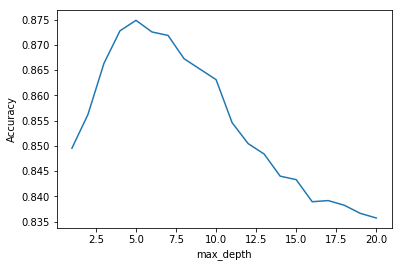

In [127]:
# plot max_depth (x-axis) versus RMSE (y-axis)
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [128]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8748840011513703, 5)

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [129]:
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range (1,n_B +1)]

In [130]:
y_pred = pd.DataFrame(index = y_test.index, columns=[list(range(n_B))])

In [131]:
for i, sample in enumerate(samples):
    X_train2 = X_train.iloc[sample,]
    y_train2 = y_train.iloc[sample,]
    tree = tree_grow(X_train2, y_train2, level=1, min_gain=0.001, max_depth=5, num_pct=10)
    y_pred[i]=tree_predict(X_test, tree)
    

In [132]:
from sklearn import metrics
Exac = 0
for i in range(n_B):
    print(i,metrics.accuracy_score(y_pred[i],y_test))
    Exac += metrics.accuracy_score(y_pred[i],y_test)


0 0.8624423963133641
1 0.8707373271889401
2 0.8700460829493087
3 0.8672811059907835
4 0.8675115207373272
5 0.8649769585253456
6 0.8612903225806452
7 0.8684331797235023
8 0.866589861751152
9 0.8691244239631336


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [222]:
def best_split(X, y, num_pct=10, max_features = 5 ):
    
    from random import shuffle
    
    cols = list(X.columns.values)
    shuffle(cols)
    X = X[cols[:max_features]]
    
    features = range(X.shape[1])
      
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [220]:
j, split, gain = best_split(X, y)
j, split, gain

(4, 51704.54545454545, 0.23348567756020572)

In [227]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=5):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct, max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [371]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=2, num_pct=10, max_features = 5)

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [2, 1.0],
 'n_samples': 13150,
 'gain': 0.04821169823599536,
 'sl': {'y_pred': 1,
  'y_prob': 0.5913779210314263,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 12408,
  'gain': 0.2271694221869982,
  'sl': {'y_pred': 0,
   'y_prob': 0.07138964577656676,
   'level': 2,
   'split': -1,
   'n_samples': 3668,
   'gain': 0.013846428346857495},
  'sr': {'y_pred': 1,
   'y_prob': 0.8096545412948982,
   'level': 2,
   'split': -1,
   'n_samples': 8740,
   'gain': 0.0032566678313979414}},
 'sr': {'y_pred': 0,
  'y_prob': 0.3817204301075269,
  'level': 1,
  'split': -1,
  'n_samples': 742,
  'gain': 0}}

In [375]:
tree_predict(X_test, tree)

array([0., 1., 1., ..., 1., 1., 0.])

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [133]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()


In [134]:
clf = RandomForestClassifier(random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
clf.predict(X_test)
metrics.accuracy_score(clf.predict(X_test), y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.83963133640553

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [135]:
# list of values to try for n_estimators
estimator_range = range(2,50,2)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

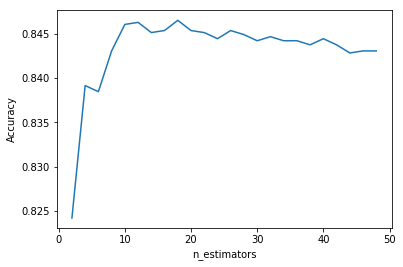

In [136]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [137]:
feature_cols = X_train.columns.values.tolist()
feature_cols

['Year',
 'Mileage',
 'M_Camry',
 'M_Camry4dr',
 'M_CamryBase',
 'M_CamryL',
 'M_CamryLE',
 'M_CamrySE',
 'M_CamryXLE']

In [138]:

# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

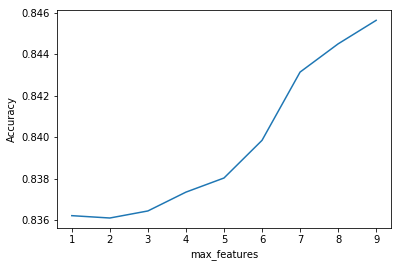

In [139]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
# numero de variables para contemplar para partir

In [142]:
clf = RandomForestClassifier(n_estimators=9, max_features=9, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
clf.predict(X_test)
metrics.accuracy_score(clf.predict(X_test), y_test)

0.8447004608294931

In [85]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000015
3,M_Camry4dr,0.001213
5,M_CamryL,0.006028
7,M_CamrySE,0.007285
2,M_Camry,0.009003
8,M_CamryXLE,0.009676
6,M_CamryLE,0.014414
0,Year,0.112871
1,Mileage,0.839494
